# Statistical analysis and Supervised Machine Learning 

In this section we will be investigating the following research questions:
- Has the number of risk to water supply in the US changed since 2017? 
- What factors are associated with greater risk to water supply in the US?
- Can we predict the number of risk to water supply? 

## Load packages and data

In [1]:
import pandas as pd
import numpy as np

#for plots 
import matplotlib.pyplot as plt

#for the poisson regression and anova 
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.formula.api import ols 
#for splitting into train vs. test data 
from sklearn.model_selection import train_test_split

#for summary statistics 
import researchpy as rp

In [2]:
#load the us data that was merged to include the information on average population, average precipiation and temperature 
us = pd.read_csv('usmerged.csv')
us

,Unnamed: 0,Year,State,Freq,Pop,Precip,Temp
0,0,2021,AL,1,5039877.0,42.51,63.0
1,95,2021,CO,2,5812069.0,11.26,45.5
2,93,2021,AZ,1,7276316.0,6.53,61.4
3,77,2021,NV,1,3143991.0,4.78,52.2
4,76,2021,NM,1,2115877.0,7.56,54.2
...,...,...,...,...,...,...,...
113,83,2017,OH,1,11659650.0,30.85,53.5
114,84,2017,PA,2,12787641.0,31.03,50.4
115,85,2017,TN,1,6708799.0,34.68,60.8
116,86,2017,TX,1,28295273.0,16.73,68.0


In [3]:
#drop the unnamed column and state name 
us.drop(['Unnamed: 0'],axis=1, inplace= True)
us.head(5)

,Year,State,Freq,Pop,Precip,Temp
0,2021,AL,1,5039877.0,42.51,63.0
1,2021,CO,2,5812069.0,11.26,45.5
2,2021,AZ,1,7276316.0,6.53,61.4
3,2021,NV,1,3143991.0,4.78,52.2
4,2021,NM,1,2115877.0,7.56,54.2


In [4]:
#check the type of each column 
us.info()

#change the type of Year to object 
us['Year'] = us['Year'].astype('object')
us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    118 non-null    int64  
 1   State   118 non-null    object 
 2   Freq    118 non-null    int64  
 3   Pop     118 non-null    float64
 4   Precip  118 non-null    float64
 5   Temp    118 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 5.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    118 non-null    object 
 1   State   118 non-null    object 
 2   Freq    118 non-null    int64  
 3   Pop     118 non-null    float64
 4   Precip  118 non-null    float64
 5   Temp    118 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 5.7+ KB


## Has the number of risk to water supply in the US changed since 2017? 

For this research question, we are essentially asking ourselves whether there is a difference between the number of risk to water supply in the US between the years. We can test this by means of a 1-way between ANOVA. Our dependent variable is the number of risk factors and our independent variable is the years (3 levels: 2017, 2018 and 2021).

The following table shows a descriptive statistics of the overall number of risk factor (*M* = 1.35, *SD* = 1.00, *N* = 118) as well as per year (2017: *M* = 1.50, *SD* = 1.33, *N* = 26; 2018: *M* = 1.35, *SD* = 1.13, *N* = 26; 2021: *M* = 1.27, *SD* = 0.75, *N* = 62).

In [5]:
#descriptive stats for the DV 
display(rp.summary_cont(us['Freq']),
        rp.summary_cont(us['Freq'].groupby(us['Year'])))

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Freq,118.0,1.3475,1.0075,0.0927,1.1638,1.5311


,N,Mean,SD,SE,95% Conf.,Interval
Year,,,,,,
2017,30,1.5000,1.3326,0.2433,1.0024,1.9976
2018,26,1.3462,1.1293,0.2215,0.8900,1.8023
2021,62,1.2742,0.7503,0.0953,1.0837,1.4647


Let's fit our 1-way anova to test our research question. 

In [6]:
#use ols to fit a simple linear regression 
aov = ols('Freq ~ Year', data=us).fit() 

#use the fitted model to obtain anova table 
aov_table = sm.stats.anova_lm(aov,typ=2) 
aov_table 

,sum_sq,df,F,PR(>F)
Year,1.030912,2.0,0.503532,0.605718
Residual,117.723325,115.0,NaN,NaN


Results show that there is no significant differences between years on the number of risk to water supply in the US (*F* = 0.50, df = 2.0, *p* = 0.61). Therefore, the number of risk to water supply in the US has remained relatively constant from 2017 until 2021.

## What factors are associated with greater risk to water supply in the US? 

For this section, we are interested in examining what factors are associated with greater risk to water supply in the US. In light of an article (Heggie, 2020) published on national geographic (https://www.nationalgeographic.com/science/article/partner-content-americas-looming-water-crisis), which suggested that warmer temperatures, decreases in rainfall and rising populations may explain why the US is running out of water, we will test whether these factors are indeed associated with greater threat to water supply in the US.

Because the dependent variable is the number of risk to water supply in the US, we will fit a Poisson regression model to analyse the count data. The independent variables are the years (2017, 2018 and 2021) as as categorical variable, the average estimated population, annual precipitation (in inches) and annual temperature (in Fahrenheit).

Let's first plot the number of risk to water supply against the independent variables for each year to get a better understanding of the data. 

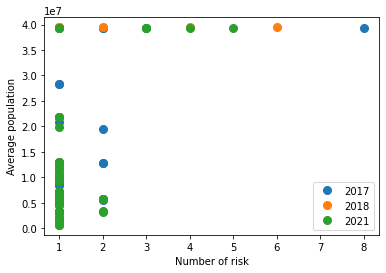

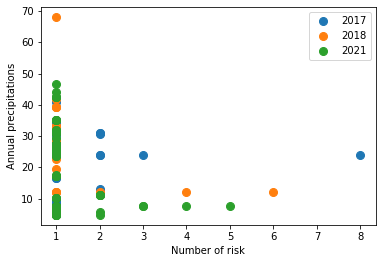

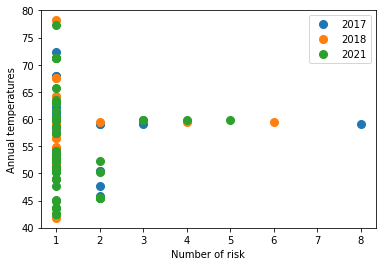

In [7]:
groups = us.groupby(['Year'])

# Plot number of risk against average population 
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group['Freq'], group['Pop'], marker='o', linestyle='', ms=8, label=name)
ax.legend()
plt.xlabel("Number of risk")
plt.ylabel("Average population")

plt.show()

# Plot number of risk against annual precipitation 
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group['Freq'], group['Precip'], marker='o', linestyle='', ms=8, label=name)
ax.legend()
plt.xlabel("Number of risk")
plt.ylabel("Annual precipitations")

plt.show()

# Plot number of risk against annual temperatures
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group['Freq'], group['Temp'], marker='o', linestyle='', ms=8, label=name)
ax.legend()
plt.xlabel("Number of risk")
plt.ylabel("Annual temperatures")

plt.show()

From the graphs, it appears that the number of risk to water supply increases as a function of the average population, especially in 2021. The relationship between the number of risk to water supply and annual precipitations and annual temperatures seems rather inconsistent. Let's test this more formally by fitting a Poisson regression model. 

We're going to now fit the regression with the number of risk as the DV and the average population estimates, annual precipitations, annual temperatures and years as a categorical value as the predictor variables

In [8]:
#fit the poisson regression model 
#C = turns the Year column into a categorical variable with 3 levels 
formula = 'Freq ~ Pop + Precip + Temp + C(Year)'
response, predictors = dmatrices(formula, us, return_type='dataframe')
po_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit()
print(po_results.summary()) #print the results 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Freq   No. Observations:                  118
Model:                            GLM   Df Residuals:                      112
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -142.69
Date:                Mon, 15 Aug 2022   Deviance:                       30.809
Time:                        21:25:29   Pearson chi2:                     35.3
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1786
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7534      0.701     

The above results are in log odds, we will turn these into odds for ease of interpretation. 

In [9]:
#turn the results into odds
params = po_results.params #get the parameters of the model with the log odds coefficient values 
conf = po_results.conf_int() #add the log odds 95% CIs to a dataframe 
conf['Odds Ratio'] = params #build a new column and add the log odds coefficient values 
conf.columns = ['5%', '95%', 'Odds Ratio'] #rename the columns 
print(np.exp(conf)) #show the results in odds by exponentiating the log odd values 

                       5%       95%  Odds Ratio
Intercept        0.537547  8.393607    2.124137
C(Year)[T.2018]  0.579284  1.420403    0.907093
C(Year)[T.2021]  0.614744  1.319958    0.900797
Pop              1.000000  1.000000    1.000000
Precip           0.980537  1.011947    0.996118
Temp             0.960999  1.014379    0.987328


Results indicate that if the average US population were to increase by one point, the difference in the expected odds number of risk to water supply in the US would be expected to increase significantly by a factor of 1.00 (*p* < 0.001, 95% CI: [1.00, 1.00]), while holding the other variables in the model constant. On the other hand, the annual precipitations, annual temperatures and year have no significant effect on number of reported risks on water supply. 

## Can we predict the number of risk to water supply? 

Having concluded that only average population estimates is a significant predictor of risk to water supply, we will fit a new model with taking into account only average population estimates as the predictor variable to test whether we can predict the number of risk to water supply. 

### Train vs. Test data 
 
We begin by splitting the data into a training set to fit our regression model on, and a test data set will be used to test the performance of our model. The training set will get 60% of the rows, while 40% of the rows will go into the test set.

In [10]:
#Let’s create the training and testing data sets.

#splits the data and puts 60% of the data into a training set and the remaining 40 percent into a testing set
#random state = randomly selects the rows
#keep at 0 to reproduce the same train test split each time you run the code   
ustrain, ustest = train_test_split(us,random_state=0,
                                   train_size = .60) 

print('Training data set has the following number of rows and columns = {}'.format(ustrain.shape))
print('Testing data set has the following number of rows and columns = {}.'.format(ustest.shape))

Training data set has the following number of rows and columns = (70, 6)
Testing data set has the following number of rows and columns = (48, 6).


In [11]:
#create the expression for the model with only the significant predictor 
expr = """Freq ~ Pop"""

#seperate the DV and predictor variables into a y and X matrices for the train and test data using the patsy library 
y_train, X_train = dmatrices(expr, ustrain, return_type='dataframe')
y_test, X_test = dmatrices(expr, ustest, return_type='dataframe')

### Train the model

In [12]:
#fit the poisson regression model 
#C = turns the Year column into a categorical variable with 3 levels 
formula = 'Freq ~ Pop'
response, predictors = dmatrices(formula, ustrain, return_type='dataframe')
train_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit()
print(train_results.summary()) #print the results 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Freq   No. Observations:                   70
Model:                            GLM   Df Residuals:                       68
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85.466
Date:                Mon, 15 Aug 2022   Deviance:                       18.748
Time:                        21:25:29   Pearson chi2:                     20.6
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1567
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0687      0.161     -0.428      0.6

Average population estimate is still a significant predictor (*p* < 0.001) of the number of risk to water supply in the US. 

### Test the performance of our model 
Let's check how well our model did by looking at some predictions on the test data.

In [13]:
#predict on test data 
poisson_predictions = train_results.predict(X_test)
poisson_predictions.head(20) #print the first 20 predictions 

86     1.006597
85     1.048321
94     1.152386
8      1.014407
89     1.283282
22     1.009523
7      1.076008
10     1.288927
45     2.478185
68     1.006597
33     1.213823
110    2.485636
2      1.118842
51     1.605102
117    1.103154
73     0.950001
30     1.081067
43     1.175657
84     2.492020
75     1.048321
dtype: float64

We can compare how our model did on the test data and training data against the actual data.

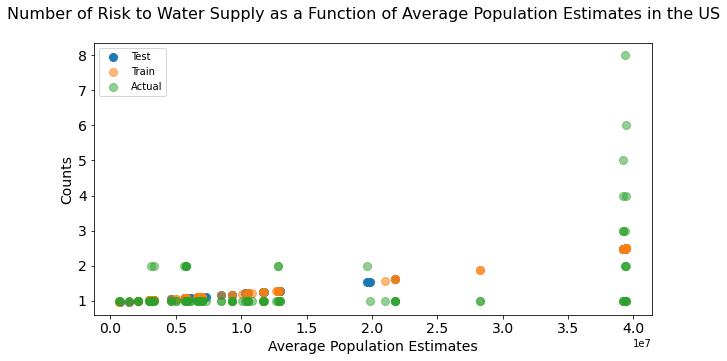

In [14]:
#Plots of the predicitive ability of model  

#actual vs predicted counts by year 
fig = plt.figure(figsize=(10,5))
fig.suptitle('Number of Risk to Water Supply as a Function of Average Population Estimates in the US', fontsize=16)
predicted = plt.plot(ustest['Pop'], train_results.predict(X_test), 'o',linestyle='',ms=8, label='Test')
train = plt.plot(ustrain['Pop'], train_results.predict(X_train), 'o', linestyle='', ms=8, alpha = 0.55, label='Train')
actual = plt.plot(us['Pop'], list(us['Freq']), 'o', linestyle='', ms=8, alpha = 0.5, label='Actual')

plt.legend()
plt.xlabel('Average Population Estimates',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tick_params(labelsize=14)

plt.show()

The model on the training and test sets seems to be more or less tracking the actual counts for smaller number of population estimates, although as we increase the average population estimates it is a lot lower than the actual counts. 

We can plot the actual vs. predicted counts to further examine this. 

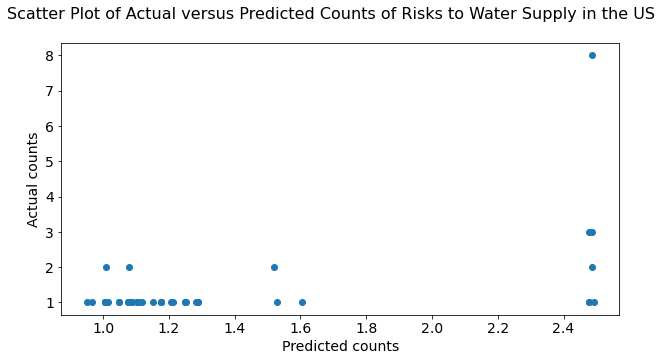

In [15]:
#actual vs predicted counts 
fig = plt.figure(figsize=(10,5))
fig.suptitle('Scatter Plot of Actual versus Predicted Counts of Risks to Water Supply in the US', fontsize=16)
plt.scatter(x=train_results.predict(X_test), y=list(ustest['Freq']), marker='o')

plt.xlabel('Predicted counts',fontsize=14)
plt.ylabel('Actual counts',fontsize=14)
plt.tick_params(labelsize=14)

plt.show()

From the expected vs. actual count graphs, it appears that our model does a great job at predicting counts of 1. However, there is room for improvement; it is unable to predict counts equal or greater than 2. In fact, our model may be suffering from underdispersion (where the variance of the model is much lower that the actual variance). This might be due to the fact that our datasets are filled with smaller counts (lots of 1s).